# Scrapbook

This notebook is used for development, its content can change at any time.

In [7]:
import timeatlas as ta
import pandas as pd

In [10]:
s = pd.read_csv("../data/bbdata/2902.csv")
s = pd.DataFrame(data=s["value"].values, index=pd.to_datetime(s["timestamp"]).values)
ts = ta.TimeSeries(s)

In [11]:
ts

                         values
2018-02-01 00:13:09.829   6.132
2018-02-01 00:28:09.753   4.971
2018-02-01 00:43:09.721   6.050
2018-02-01 00:58:09.638   6.056
2018-02-01 01:13:09.588   6.187
...                         ...
2018-02-01 22:58:04.549   6.065
2018-02-01 23:13:04.487   5.414
2018-02-01 23:28:04.422   5.707
2018-02-01 23:43:04.373   6.188
2018-02-01 23:58:04.327   5.326

[95 rows x 1 columns]

In [12]:
ts.erase()

                         values
2018-02-01 00:13:09.829     NaN
2018-02-01 00:28:09.753     NaN
2018-02-01 00:43:09.721     NaN
2018-02-01 00:58:09.638     NaN
2018-02-01 01:13:09.588     NaN
...                         ...
2018-02-01 22:58:04.549     NaN
2018-02-01 23:13:04.487     NaN
2018-02-01 23:28:04.422     NaN
2018-02-01 23:43:04.373     NaN
2018-02-01 23:58:04.327     NaN

[95 rows x 1 columns]

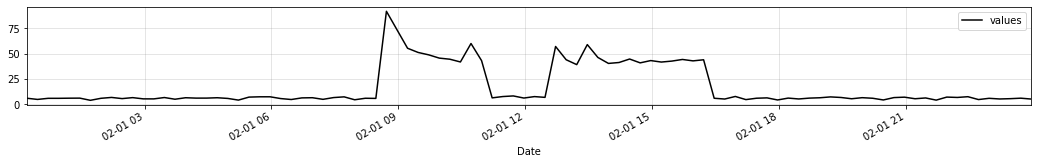

In [13]:
ts.plot()

In [14]:
ts.describe()

,values
count,95.000000
mean,16.754200
std,19.096193
min,4.095000
25%,5.959500
50%,6.620000
75%,23.790001
max,91.604996


In [15]:
ts.min()

values    4.095
dtype: float64

In [16]:
ts.max()

values    91.604996
dtype: float64

In [17]:
ts.boundaries()

(Timestamp('2018-02-01 00:13:09.829000'),
 Timestamp('2018-02-01 23:58:04.327000'))

In [18]:
ts.duration()

Timedelta('0 days 23:44:54.498000')

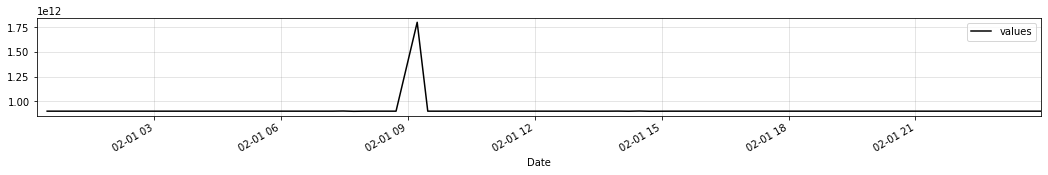

In [19]:
ts.resolution().plot()

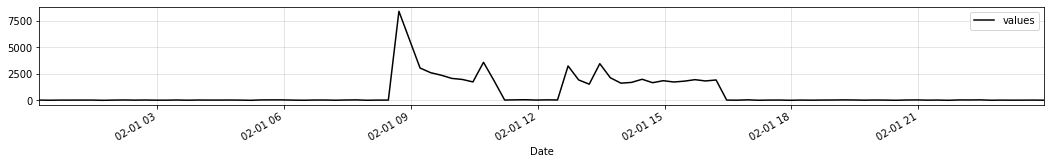

In [21]:
ts.apply(lambda x : x**2).plot()

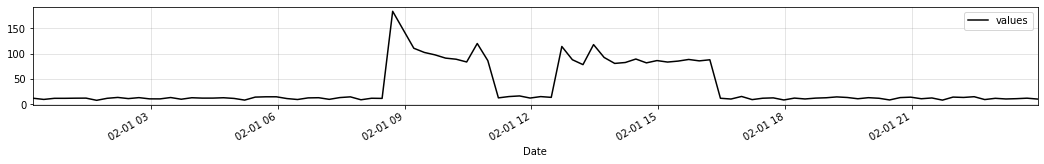

In [22]:
ts.apply(lambda x,y: x+y, ts).plot()

## Define a Metadata object

In [ ]:
from timeatlas import Metadata, types

# You can use some typed metadata object
my_unit = types.Unit("power", "W", "float")
my_sensor = types.Sensor(2902, "HB/floor2/22-23C/Prises_Power_Tot")

# Or use Python dictionaries
my_location = {
    "building" : "Blue Factory",
    "floor" : "12",
    "room"  : "22C"
}
my_coordinates = {
    "lat" : 46.796611,
    "lon" : 7.147563
}
my_dict = {
    "unit": my_unit,
    "sensor": my_sensor,
    "location": my_location,
    "coordinates": my_coordinates
}

# Create the Metadata object
my_meta = Metadata(my_dict)


## Define a TimeSeries with Metadata

In [ ]:
ts_meta = TimeSeries(s, my_meta)
ts_meta

## Make Predictions

Some definitions:

- `time series` : self-explanatory, i.e. the TimeSeries object
- `horizon` : the duration to predict after the last value of the time series
- `frequency`: the number of values per unit of time. Usually, the frequency is given in Pandas offset aliases (https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases)

```
                                horizon
   |-------------------------|- - - - - -|
                             |||||||||||||
           time series         frequency

```

In [ ]:
from timeatlas import models

In [ ]:
m1 = models.Prophet()
m1.fit(ts_meta)
pts1 = m1.predict(ts_meta)
pts2 = m1.predict("24 hours")

In [ ]:
m2 = models.LinearRegression()
m2.fit(ts_meta)
pts3 = m2.predict(ts_meta)
pts4 = m2.predict("14 days")

In [ ]:
from timeatlas import plots

plots.prediction(ts_meta, pts1)

## Detect Anomalies


In [ ]:
from timeatlas import detectors, metrics

In [ ]:
ts.apply(lambda x: x+1).series.head()

In [ ]:
# Create the base of the detector. 
# i.e. this detector is based on this model and compute this error
d = detectors.Surprise(m1, metrics.relative_error)

# Set the alerts
d.alerts("quantile", [0.65, 0.8, 0.85, 0.95])\

# Fit the detector with a specific Time Series
d.fit(ts_meta)

In [ ]:
# Detect anomalies with the fitted detector
a = d.detect(ts2)

In [ ]:
a.plot()

In [ ]:
d.truth.plot()
d.prediction.plot()

## Scalers

In [ ]:
from timeatlas.processing import scalers

In [ ]:
ts_meta.plot()

In [ ]:
y = scalers.minmax(ts_meta)

In [ ]:
y.plot()